In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from pandas.io.json import json_normalize
import json
import os
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [2]:
def load_df(csv_path='/home/baitong/pywork/RevenuePrediction/all/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
#     print(df.head())
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
path = '/home/baitong/pywork/RevenuePrediction/'

In [4]:
%%time
train = load_df()
test = load_df(csv_path='/home/baitong/pywork/RevenuePrediction/all/test.csv')


Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 3min 53s, sys: 4.41 s, total: 3min 57s
Wall time: 4min 5s


In [5]:
# channelGrouping                object
# date                           object
# fullVisitorId                  object
# sessionId                      object
# visitId                        object
# visitNumber                   float64
# visitStartTime                float64
# device.browser                 object
# device.deviceCategory          object
# device.isMobile               float64
# device.operatingSystem         object
# geoNetwork.city                object
# geoNetwork.continent           object
# geoNetwork.country             object
# geoNetwork.metro               object
# geoNetwork.networkDomain       object
# geoNetwork.region              object
# geoNetwork.subContinent        object
# totals.bounces                float64
# totals.hits                   float64
# totals.newVisits              float64
# totals.pageviews              float64
# totals.transactionRevenue     float64
# trafficSource.adContent        object
# trafficSource.campaign         object
# trafficSource.isTrueDirect    float64
# trafficSource.keyword          object
# trafficSource.medium           object
# trafficSource.referralPath     object
# trafficSource.source           object
# dtype: object

In [5]:
train_store_1 = pd.read_csv('/home/baitong/pywork/RevenuePrediction/all/Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('/home/baitong/pywork/RevenuePrediction/all/Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('/home/baitong/pywork/RevenuePrediction/all/Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('/home/baitong/pywork/RevenuePrediction/all/Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

In [6]:
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(str)

In [7]:
train_exdata = pd.concat([train_store_1, train_store_2], sort=False)
test_exdata = pd.concat([test_store_1, test_store_2], sort=False)

for df in [train, test]:
    df["visitId"] = df["visitId"].astype(str)

# Merge with train/test data
train_new = train.merge(train_exdata, how="left", on="visitId")
test_new = test.merge(test_exdata, how="left", on="visitId")

In [8]:
# Drop Client Id
for df in [train_new, test_new]:
    df.drop("Client Id", 1, inplace=True)

#Cleaning Revenue
for df in [train_new, test_new]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

In [9]:
for df in [train_new, test_new]:
    df["Sessions"] = df["Sessions"].fillna(0)
    df["Avg. Session Duration"] = df["Avg. Session Duration"].fillna(0)
    df["Bounce Rate"] = df["Bounce Rate"].fillna(0)
    df["Revenue"] = df["Revenue"].fillna(0)
    df["Transactions"] = df["Transactions"].fillna(0)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].fillna(0)
    df['trafficSource_adContent'].fillna('N/A', inplace=True)
    df['trafficSource_isTrueDirect'].fillna('N/A', inplace=True)
    df['trafficSource_referralPath'].fillna('N/A', inplace=True)
    df['trafficSource_keyword'].fillna('N/A', inplace=True)
    df['totals_bounces'].fillna(0.0, inplace=True)
    df['totals_newVisits'].fillna(0.0, inplace=True)
    df['totals_pageviews'].fillna(0.0, inplace=True)

In [11]:
test_new[test_new.Sessions>0]

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
225,Referral,20171016,189964941516162209,189964941516162209_1508200618,Not Socially Engaged,1508200618,1,1508200618,Chrome,not available in demo dataset,...,N/A,referral,/,mall.googleplex.com,7.0,00:07:51,28.57%,174.57,2.0,71.43%
536,Referral,20171016,9202414187998122557,9202414187998122557_1508175924,Not Socially Engaged,1508175924,1,1508175924,Chrome,not available in demo dataset,...,N/A,referral,/,mall.googleplex.com,4.0,00:13:29,0.00%,345.56,2.0,175.00%
583,Organic Search,20171016,1241641497550958336,1241641497550958336_1508201423,Not Socially Engaged,1508201423,3,1508201423,Chrome,not available in demo dataset,...,(not provided),organic,N/A,google,2.0,00:01:25,0.00%,1599.34,2.0,200.00%
670,Referral,20171016,2534051358403193307,2534051358403193307_1508206558,Not Socially Engaged,1508206558,1,1508206558,Chrome,not available in demo dataset,...,N/A,referral,/,mall.googleplex.com,21.0,00:04:50,19.05%,349.14,2.0,57.14%
974,Direct,20171016,4308356202673642383,4308356202673642383_1508190842,Not Socially Engaged,1508190842,1,1508190842,Chrome,not available in demo dataset,...,N/A,(none),N/A,(direct),16.0,00:07:04,0.00%,127.45,4.0,118.75%
988,Referral,20171016,3647954292650000896,3647954292650000896_1508178162,Not Socially Engaged,1508178162,1,1508178162,Chrome,not available in demo dataset,...,N/A,referral,/,mall.googleplex.com,14.0,00:08:26,14.29%,502.71,5.0,200.00%
1008,Referral,20171016,8530613607503742741,8530613607503742741_1508193456,Not Socially Engaged,1508193456,1,1508193456,Chrome,not available in demo dataset,...,N/A,referral,/,mall.googleplex.com,2.0,00:12:28,0.00%,28.18,2.0,450.00%
1680,Organic Search,20171016,5108169296130448247,5108169296130448247_1508175924,Not Socially Engaged,1508175924,2,1508175924,Chrome,not available in demo dataset,...,(not provided),organic,N/A,google,4.0,00:13:29,0.00%,345.56,2.0,175.00%
1784,Referral,20171016,480773587297538354,480773587297538354_1508186287,Not Socially Engaged,1508186287,1,1508186287,Chrome,not available in demo dataset,...,N/A,referral,/,mall.googleplex.com,152.0,00:02:40,51.97%,51.14,2.0,24.34%
1920,Referral,20171016,5315786461950075561,5315786461950075561_1508186291,Not Socially Engaged,1508186291,1,1508186291,Chrome,not available in demo dataset,...,N/A,referral,/,mall.googleplex.com,18.0,00:03:05,11.11%,114.26,2.0,61.11%


In [12]:
del train
del test
train = train_new
test = test_new
del train_new
del test_new
gc.collect()

21

In [13]:
#获取不变的常量列，模型无法在常量数据计学到东西，数据与处理时需要drop
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
print(const_cols)

['socialEngagementType', 'device_browserSize', 'device_browserVersion', 'device_flashVersion', 'device_language', 'device_mobileDeviceBranding', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_operatingSystemVersion', 'device_screenColors', 'device_screenResolution', 'geoNetwork_cityId', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits', 'trafficSource_adwordsClickInfo.criteriaParameters']


In [14]:
const_cols2=['socialEngagementType', 'device_browserSize', 'device_browserVersion', 'device_flashVersion', 'device_language', 'device_mobileDeviceBranding', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_operatingSystemVersion', 'device_screenColors', 'device_screenResolution', 'geoNetwork_cityId', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits', 'trafficSource_adwordsClickInfo.criteriaParameters']

In [15]:
train = train.drop(const_cols , axis=1)
test = test.drop(const_cols2, axis=1)


In [16]:
####删除test中不存在的列
train = train.drop(["trafficSource_campaignCode"], axis=1)
train.shape, test.shape

((903654, 41), (804686, 40))

In [17]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [18]:
train['totals_transactionRevenue'] = train['totals_transactionRevenue'].fillna(0).astype("float")
# del train['totals_transactionRevenue']

# if 'totals_transactionRevenue' in test.columns:
#     del test['totals_transactionRevenue']

In [19]:
train.shape, test.shape

((903654, 41), (804686, 40))

In [20]:
train.drop(['trafficSource_adwordsClickInfo.adNetworkType','trafficSource_adwordsClickInfo.gclId',
          'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_adwordsClickInfo.page',
           'trafficSource_adwordsClickInfo.slot'],axis =1,inplace = True)
test.drop(['trafficSource_adwordsClickInfo.adNetworkType','trafficSource_adwordsClickInfo.gclId',
          'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_adwordsClickInfo.page',
        'trafficSource_adwordsClickInfo.slot'],axis =1,inplace = True)

In [21]:
train.shape, test.shape

((903654, 36), (804686, 35))

In [22]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,...,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,(not provided),organic,N/A,google,0.0,0,0,0.0,0.0,0
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,(not provided),organic,N/A,google,0.0,0,0,0.0,0.0,0
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,(not provided),organic,N/A,google,0.0,0,0,0.0,0.0,0
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,google + online,organic,N/A,google,0.0,0,0,0.0,0.0,0
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,(not provided),organic,N/A,google,0.0,0,0,0.0,0.0,0


In [23]:
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [24]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'Sessions', 'Avg. Session Duration',
       'Bounce Rate', 'Revenue', 'Transactions', 'Goal Conversion Rate'],
      dtype='object')

In [25]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [ ]:
# train.info()

In [26]:
def dealMissingData(df):
    for c in df.columns:
        num_missing = df[c].isnull().sum() 
        if num_missing != 0:
            print("missing col is  ",c,'   missing num is',num_missing)
    num_feature = ["totals_bounces","totals_newVisits"]
    cat_feature = ['trafficSource_adContent','trafficSource_adContent',
                  'trafficSource_campaign','trafficSource_isTrueDirect',
                  'trafficSource_keyword','trafficSource_referralPath']
    for col in num_feature:
        df[col].fillna(0,inplace=True)
    for col in cat_feature:
        df[col].fillna(-999,inplace=True)
    for c in df.columns:
        num_missing = df[c].isnull().sum() 
        if num_missing != 0:
            print("missing col is  ",c,'   missing num is',num_missing)
    return df

In [27]:
train = dealMissingData(train)
test = dealMissingData(test)

In [28]:
clearRare("device_browser")
clearRare("device_operatingSystem")
clearRare("geoNetwork_country")
clearRare("geoNetwork_city")
clearRare("geoNetwork_metro")
clearRare("geoNetwork_networkDomain")
clearRare("geoNetwork_region")
clearRare("geoNetwork_subContinent")
clearRare("trafficSource_adContent")
clearRare("trafficSource_campaign")
clearRare("trafficSource_keyword")
clearRare("trafficSource_medium")
clearRare("trafficSource_referralPath")
clearRare("trafficSource_source")

Set 98 device_browser categories to 'other'; now there are 11 categories in train
Set 15 device_operatingSystem categories to 'other'; now there are 8 categories in train
Set 160 geoNetwork_country categories to 'other'; now there are 60 categories in train
Set 656 geoNetwork_city categories to 'other'; now there are 77 categories in train
Set 86 geoNetwork_metro categories to 'other'; now there are 24 categories in train
Set 25689 geoNetwork_networkDomain categories to 'other'; now there are 62 categories in train
Set 314 geoNetwork_region categories to 'other'; now there are 62 categories in train
Set 5 geoNetwork_subContinent categories to 'other'; now there are 19 categories in train
Set 46 trafficSource_adContent categories to 'other'; now there are 4 categories in train
Set 23 trafficSource_campaign categories to 'other'; now there are 5 categories in train
Set 2409 trafficSource_keyword categories to 'other'; now there are 8 categories in train
Set 1 trafficSource_medium categor

In [29]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

In [30]:
###填补totals.pageviews值
predmis = train[train['totals_pageviews'].isnull()]['totals_hits'].values
train.loc[(train['totals_pageviews'].isnull()),'totals_pageviews' ] = predmis

predmis = test[test['totals_pageviews'].isnull()]['totals_hits'].values
test.loc[(test['totals_pageviews'].isnull()),'totals_pageviews' ] = predmis


In [31]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!

In [ ]:
# train['weekday'].value_counts()

In [32]:
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

/home/baitong/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [33]:
for df in [train, test]:
    df['source_country'] = df['trafficSource_source'] + '_' + df['geoNetwork_country']
    df['campaign_medium'] = df['trafficSource_campaign'] + '_' + df['trafficSource_medium']
    df['browser_category'] = df['device_browser'] + '_' + df['device_deviceCategory']
    df['browser_os'] = df['device_browser'] + '_' + df['device_operatingSystem']

In [34]:
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device_deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device_browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device_operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country','geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region','geoNetwork_subContinent']:
        for j in ['device_browser','device_deviceCategory', 'device_operatingSystem', 'trafficSource_source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content_source'] = df['trafficSource_adContent'].astype(str) + "_" + df['source_country']
    df['medium_source'] = df['trafficSource_medium'] + "_" + df['source_country']

In [35]:
train['totals_hits'] = train['totals_hits'].astype("float")
test['totals_hits'] = test['totals_hits'].astype("float")
train['totals_pageviews'] = train['totals_pageviews'].astype("float")
test['totals_pageviews'] = test['totals_pageviews'].astype("float")


In [36]:
for feature in ["totals_hits", "totals_pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

In [37]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals_transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]
print("cat_cols: ",cat_cols)
print("real_cols: ",real_cols)

cat_cols:  ['Avg. Session Duration', 'Bounce Rate', 'Goal Conversion Rate', 'channelGrouping', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces', 'totals_newVisits', 'trafficSource_adContent', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'weekday', 'source_country', 'campaign_medium', 'browser_category', 'browser_os', 'device_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork_city_device_browser', 'geoNetwork_city_device_deviceCategory', 'geoNetwork_city_device_operatingSystem', 'geoNetwork_city_trafficSource_source', 'geoNetwork_continent_device_browser', 'geoNetwork_continent_device_deviceCategory', 'geoNetwork_continent_device_operatin

In [38]:
train[cat_cols].nunique()

Avg. Session Duration                               952
Bounce Rate                                          45
Goal Conversion Rate                                 84
channelGrouping                                       8
device_browser                                       11
device_deviceCategory                                 3
device_operatingSystem                                8
geoNetwork_city                                      77
geoNetwork_continent                                  6
geoNetwork_country                                   60
geoNetwork_metro                                     24
geoNetwork_networkDomain                             62
geoNetwork_region                                    62
geoNetwork_subContinent                              19
totals_bounces                                        2
totals_newVisits                                      2
trafficSource_adContent                               4
trafficSource_campaign                          

In [39]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [40]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [41]:
y_reg = train['totals_transactionRevenue']

In [42]:
folds = get_folds(df=train, n_splits=5)

train_features = real_cols + cat_cols
importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x,np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.60653	valid_0's l2: 2.58093
[200]	valid_0's rmse: 1.58722	valid_0's l2: 2.51926
[300]	valid_0's rmse: 1.58137	valid_0's l2: 2.50072
[400]	valid_0's rmse: 1.57852	valid_0's l2: 2.49172
[500]	valid_0's rmse: 1.57711	valid_0's l2: 2.48729
Early stopping, best iteration is:
[514]	valid_0's rmse: 1.57672	valid_0's l2: 2.48603
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.57904	valid_0's l2: 2.49336
[200]	valid_0's rmse: 1.56182	valid_0's l2: 2.43929
[300]	valid_0's rmse: 1.55703	valid_0's l2: 2.42434
[400]	valid_0's rmse: 1.55374	valid_0's l2: 2.41411
[500]	valid_0's rmse: 1.55216	valid_0's l2: 2.40919
[600]	valid_0's rmse: 1.55104	valid_0's l2: 2.40572
[700]	valid_0's rmse: 1.55059	valid_0's l2: 2.40433
[800]	valid_0's rmse: 1.55066	valid_0's l2: 2.40456
Early stopping, best iteration is:
[771]	valid_0's rmse: 1.55045	valid_0's l2: 2.40389
Training until validation 

1.5625753904314237

In [43]:
len(oof_reg_preds),len(train)

(903654, 903654)

In [44]:
len(sub_reg_preds),len(test)

(804686, 804686)

In [45]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

In [46]:
##计算单个用户会话总数
train["sess_count"]=1;
train_sess_num = train[['fullVisitorId', 'sess_count']].groupby('fullVisitorId').sum()
test["sess_count"]=1;
test_sess_num = test[['fullVisitorId', 'sess_count']].groupby('fullVisitorId').sum()

In [47]:
###将大于20次的会话数量限制为20 （大于20次数据过少）
train_sess_num['sess_count']=train_sess_num['sess_count'].apply(lambda x: 20 if x>20 else x)
test_sess_num['sess_count']=test_sess_num['sess_count'].apply(lambda x: 20 if x>20 else x)

In [48]:
# train_sess_num['sess_count'].value_counts()

In [49]:
####这里采用均值合并，对于类型特征来说并不合理
train_agg = train[train_features+['fullVisitorId']].groupby('fullVisitorId').mean()

In [50]:
train_pred = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()
len(train_pred)

714167

In [51]:
train_fulldata = pd.concat([train_agg, train_pred,train_sess_num], axis=1).astype(float)

In [52]:
test_agg = test[train_features+['fullVisitorId']].groupby('fullVisitorId').mean()
test_pred = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()
test_fulldata = pd.concat([test_agg, test_pred,test_sess_num], axis=1).astype(float)

In [53]:
test_fulldata.shape,train_fulldata.shape

((617242, 76), (714167, 76))

In [54]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [55]:
test_fulldata.head(0)

,Revenue,Sessions,Transactions,device_isMobile,time,totals_hits,totals_pageviews,visitNumber,prev_session,next_session,...,geoNetwork_region_device_operatingSystem,geoNetwork_region_trafficSource_source,geoNetwork_subContinent_device_browser,geoNetwork_subContinent_device_deviceCategory,geoNetwork_subContinent_device_operatingSystem,geoNetwork_subContinent_trafficSource_source,content_source,medium_source,predictions,sess_count
fullVisitorId,,,,,,,,,,,,,,,,,,,,,


In [56]:
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

lgb_oof_preds = np.zeros(train_fulldata.shape[0])
lgb_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    lgb_oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    lgb_oof_preds[lgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(test_fulldata[train_fulldata.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    lgb_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), lgb_oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.45898	TRAIN's l2: 2.12861	VALID's rmse: 1.50694	VALID's l2: 2.27087
[200]	TRAIN's rmse: 1.42306	TRAIN's l2: 2.02511	VALID's rmse: 1.50225	VALID's l2: 2.25677
Early stopping, best iteration is:
[179]	TRAIN's rmse: 1.42843	TRAIN's l2: 2.04041	VALID's rmse: 1.50195	VALID's l2: 2.25586
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.4575	TRAIN's l2: 2.12429	VALID's rmse: 1.50803	VALID's l2: 2.27417
[200]	TRAIN's rmse: 1.42217	TRAIN's l2: 2.02256	VALID's rmse: 1.50391	VALID's l2: 2.26173
Early stopping, best iteration is:
[204]	TRAIN's rmse: 1.42136	TRAIN's l2: 2.02025	VALID's rmse: 1.50377	VALID's l2: 2.26133
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.4602	TRAIN's l2: 2.1322	VALID's rmse: 1.49923	VALID's l2: 2.24769
[200]	TRAIN's rmse: 1.42433	TRAIN's l2: 2.02871	VALID's rmse: 1.49575	VALID's l2: 2.23728
Early stopping, best iterat

1.497669874268843

/home/baitong/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


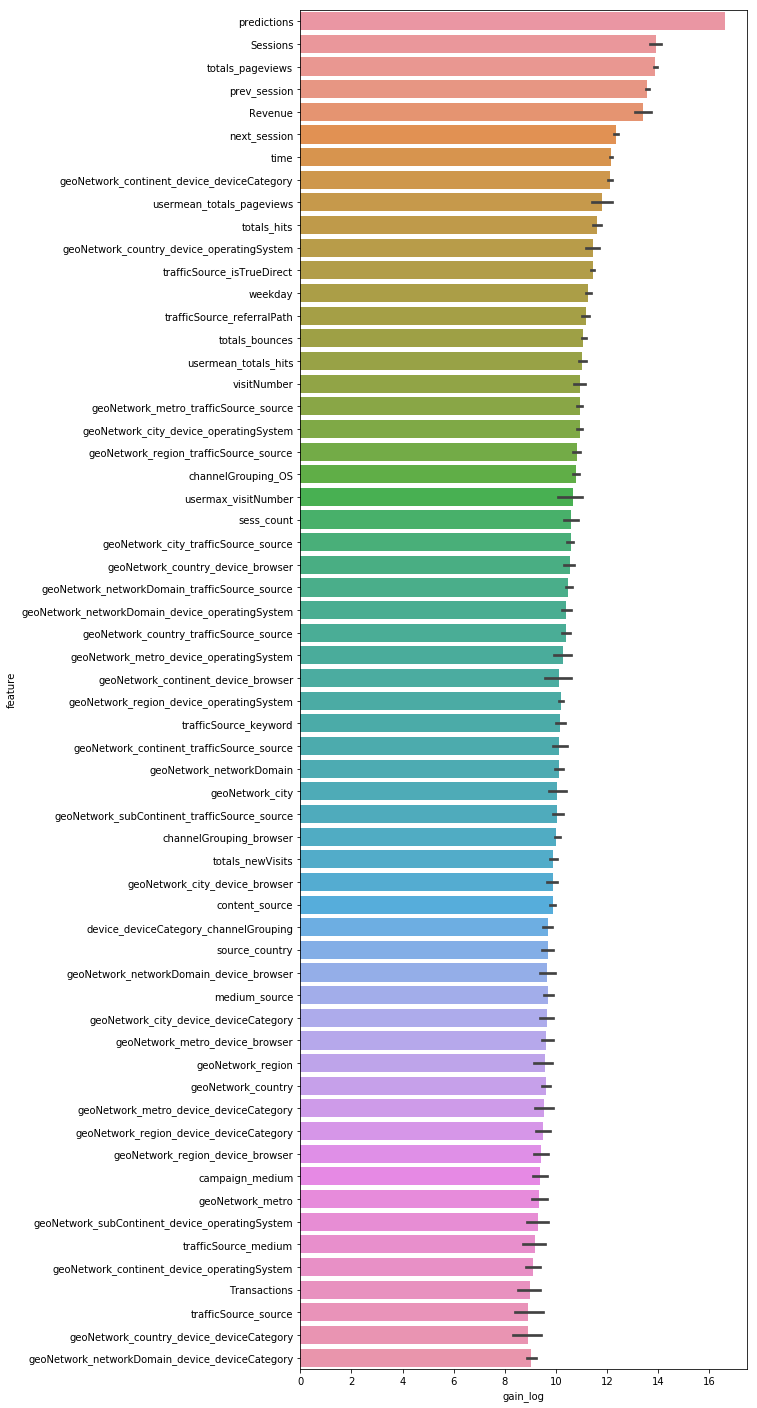

In [57]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [60]:
test_fulldata['PredictedLogRevenue'] = lgb_sub_preds
test_fulldata[['PredictedLogRevenue']].to_csv('/home/baitong/pywork/RevenuePrediction/submission.csv', index=True)

In [61]:
xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

In [62]:
from xgboost import XGBRegressor
fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}

folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

xgb_oof_preds = np.zeros(train_fulldata.shape[0])
xgb_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    xgb = XGBRegressor(**xgb_params, n_estimators=1300)
    
    xgb.fit(trn_x, np.log1p(trn_y),
            eval_set=[(val_x, np.log1p(val_y))],
            early_stopping_rounds=50,
            eval_metric='rmse',
            verbose=100)
    
    xgb_oof_preds[val_] = xgb.predict(val_x)
    xgb_oof_preds[xgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = xgb.predict(test_fulldata[train_fulldata.columns])
    _preds[_preds < 0] = 0
    xgb_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), xgb_oof_preds) ** .5

[0]	validation_0-rmse:2.10283
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.71476
[200]	validation_0-rmse:1.60991
[300]	validation_0-rmse:1.56561
[400]	validation_0-rmse:1.54929
[500]	validation_0-rmse:1.54222
[600]	validation_0-rmse:1.53403
[700]	validation_0-rmse:1.53096
[800]	validation_0-rmse:1.52688
[900]	validation_0-rmse:1.52564
[999]	validation_0-rmse:1.52497
[0]	validation_0-rmse:2.10344
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.73527
[200]	validation_0-rmse:1.61556
[300]	validation_0-rmse:1.5741
[400]	validation_0-rmse:1.55598
[500]	validation_0-rmse:1.53819
[600]	validation_0-rmse:1.5337
[700]	validation_0-rmse:1.52756
[800]	validation_0-rmse:1.52504
Stopping. Best iteration:
[813]	validation_0-rmse:1.52409

[0]	validation_0-rmse:2.0977
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.75211
[200]	validation_0-rmse:1.62028
[300]	validation_0-

1.5221570700953595

In [63]:
cat_param = {
    'learning_rate' :0.03,
    'depth' :10,
    'eval_metric' :'RMSE',
    'od_type' :'Iter',
    'metric_period ' : 50,
    'od_wait' : 20,
    'seed' : 42
    
}

In [64]:
from catboost import CatBoostRegressor
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

cat_oof_preds = np.zeros(train_fulldata.shape[0])
cat_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    cat = CatBoostRegressor(iterations=1000,learning_rate=0.03,
                            depth=10,
                            eval_metric='RMSE',
                            random_seed = 42,
                            bagging_temperature = 0.2,
                            od_type='Iter',
                            metric_period = 50,
                            od_wait=20)
    cat.fit(trn_x, np.log1p(trn_y), 
            eval_set=[(val_x, np.log1p(val_y))],
            early_stopping_rounds=50,
            use_best_model=True,
            verbose=100)
    cat_oof_preds[val_] = cat.predict(val_x)
    cat_oof_preds[cat_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = cat.predict(test_fulldata[train_fulldata.columns])
    _preds[_preds < 0] = 0
    cat_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), cat_oof_preds) ** .5

0:	learn: 2.0838310	test: 2.0842327	best: 2.0842327 (0)	total: 260ms	remaining: 4m 19s
100:	learn: 1.4710787	test: 1.5082475	best: 1.5082475 (100)	total: 20.8s	remaining: 3m 5s
200:	learn: 1.4345318	test: 1.5034897	best: 1.5034222 (189)	total: 41.3s	remaining: 2m 44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.503410433
bestIteration = 202

Shrink model to first 203 iterations.


0:	learn: 2.0836769	test: 2.0861750	best: 2.0861750 (0)	total: 206ms	remaining: 3m 26s
100:	learn: 1.4695531	test: 1.5109014	best: 1.5109014 (100)	total: 21s	remaining: 3m 7s
200:	learn: 1.4342020	test: 1.5064363	best: 1.5063446 (190)	total: 41.6s	remaining: 2m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.506344643
bestIteration = 190

Shrink model to first 191 iterations.


0:	learn: 2.0830977	test: 2.0868480	best: 2.0868480 (0)	total: 213ms	remaining: 3m 32s
100:	learn: 1.4704438	test: 1.5030618	best: 1.5030618 (100)	total: 21.2s	remaining: 3m 8s
200:	learn: 1.4338489	test: 1.4990704	best: 1.4989677 (191)	total: 42s	remaining: 2m 47s
300:	learn: 1.4047804	test: 1.4988537	best: 1.4985653 (274)	total: 1m 2s	remaining: 2m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.498565298
bestIteration = 274

Shrink model to first 275 iterations.


0:	learn: 2.0869018	test: 2.0717274	best: 2.0717274 (0)	total: 204ms	remaining: 3m 23s
100:	learn: 1.4777217	test: 1.4821371	best: 1.4821164 (99)	total: 20.8s	remaining: 3m 5s
200:	learn: 1.4408545	test: 1.4789337	best: 1.4788784 (196)	total: 41.7s	remaining: 2m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.478876555
bestIteration = 201

Shrink model to first 202 iterations.


0:	learn: 2.0822685	test: 2.0916353	best: 2.0916353 (0)	total: 212ms	remaining: 3m 32s
100:	learn: 1.4661042	test: 1.5175700	best: 1.5175700 (100)	total: 21.6s	remaining: 3m 11s
200:	learn: 1.4288746	test: 1.5131066	best: 1.5131066 (200)	total: 42.8s	remaining: 2m 50s
300:	learn: 1.3992379	test: 1.5139887	best: 1.5126367 (250)	total: 1m 4s	remaining: 2m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.512636714
bestIteration = 250

Shrink model to first 251 iterations.


1.5000026195754337

In [65]:
test_fulldata['lgb_pred'] = lgb_sub_preds
test_fulldata['xgb_pred'] = xgb_sub_preds
test_fulldata['cst_pred'] = cat_sub_preds
test_final_data = test_fulldata[['lgb_pred','xgb_pred','cst_pred']]

In [66]:
train_fulldata['lgb_pred'] = lgb_oof_preds
train_fulldata['xgb_pred'] = xgb_oof_preds
train_fulldata['cst_pred'] = cat_oof_preds
train_final_data = train_fulldata[['lgb_pred','xgb_pred','cst_pred']]

In [67]:
from sklearn.linear_model import LinearRegression

folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

final_oof_preds = np.zeros(train_final_data.shape[0])
final_sub_preds = np.zeros(test_final_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_final_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_final_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    lin_reg = LinearRegression()
    lin_reg.fit(trn_x,np.log1p(trn_y))
    final_oof_preds[val_] = lin_reg.predict(val_x)
    final_oof_preds[final_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = lin_reg.predict(test_final_data[train_final_data.columns])
    _preds[_preds < 0] = 0
    final_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), final_oof_preds) ** .5

1.495455966046259

In [68]:
len(final_sub_preds)

617242

In [69]:
test_fulldata['PredictedLogRevenue'] = final_sub_preds

test_fulldata[['PredictedLogRevenue']].to_csv('/home/baitong/pywork/RevenuePrediction/submission.csv', index=True)